# Study of all features we can extract from messages 

In [3]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasgrau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasgrau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasgrau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Create a data dataframe with all train data and their labels

In [4]:
train_transcription_df = pd.read_csv('train_transcriptions_df.csv')
training_labels_df = pd.read_csv('training_labels_df.csv')
test_transcription_df = pd.read_csv('test_transcriptions_df.csv')
data = pd.merge(train_transcription_df, training_labels_df, on =['transcription_id', "index"])
transcriptions_ids = data['transcription_id'].unique()
data.head()

,speaker,text,index,transcription_id,label
0,PM,Okay,0,ES2002a,0
1,PM,Right,1,ES2002a,0
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1
3,PM,Um <vocalsound> and um,3,ES2002a,0
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0


# Clean messages before analysis

In [5]:
def preprocess_sentence(text):
    text = re.sub(r'<[^>]+>', ' ', text) # Remove content within <>
    text = re.sub(r'\s+', ' ', text)     # Replace multiple spaces with a single space
    text = text.strip()                  # Remove leading and trailing spaces
    text = text.lower()                  # Convert to lowercase to maintain consistency
    return text

data['cleaned_text'] = data['text'].apply(preprocess_sentence)
test_transcription_df['cleaned_text'] = test_transcription_df['text'].apply(preprocess_sentence)
data.head()

,speaker,text,index,transcription_id,label,cleaned_text
0,PM,Okay,0,ES2002a,0,okay
1,PM,Right,1,ES2002a,0,right
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...


## TF-IDF score

It gives us the score of the importance of the message regarding the vocabulary of the corpus.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=word_tokenize)
data['tfidf_score'] = tfidf.fit_transform(data['cleaned_text']).mean(axis=1)
data.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score
0,PM,Okay,0,ES2002a,0,okay,0.000114
1,PM,Right,1,ES2002a,0,right,0.000114
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448


## TF-IDF per speaker 

Because a speaker can have its own expression, it might be useful to compute the tf-idf score per speaker.

In [7]:
data['tfidf_score_per_speaker'] = np.nan
for speaker in data['speaker'].unique():
    speaker_transcription = data[data['speaker'] == speaker]
    corpus = speaker_transcription['cleaned_text'].tolist()
    corpus = [' '.join(doc).split() for doc in corpus]
    vectoriser = TfidfVectorizer(tokenizer=word_tokenize)
    vectoriser.fit_transform([' '.join(doc) for doc in corpus])
    speaker_indices = data[data['speaker'] == speaker].index
    speaker_data = vectoriser.transform(data.loc[speaker_indices, 'cleaned_text'])
    data.loc[speaker_indices, 'tfidf_score_per_speaker'] = speaker_data.mean(axis=1).A1  # Convert to a 1D array
data.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125


## Word2Vec

Vectoriser for each sentences, applying the mean over all words of the sentence.

In [8]:

# Prétraitement et tokenisation des phrases
sentences = [word_tokenize(sentence) for sentence in data['cleaned_text'].tolist() +test_transcription_df['cleaned_text'].tolist() ]
# Entraînement du modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=50, window=5, min_count=5, sg=1, hs=0, epochs=10, workers=4)

In [9]:
def sentence_to_avg_vector(sentence, model):
    words = word_tokenize(sentence)
    word_vectors = []
    for word in words:
        word_vectors.append(model.wv[word] if word in model.wv else np.zeros(model.vector_size))
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)
    
X_word2vec = data['cleaned_text'].apply(lambda sentence: sentence_to_avg_vector(sentence, word2vec_model))
# Convertir X_word2vec en une liste de vecteurs, puis en une matrice NumPy
X_word2vec_matrix = np.vstack(X_word2vec.values)
X_word2vec_df = pd.DataFrame(X_word2vec_matrix)

# concaténation des deux dataframes
data = pd.concat([data, X_word2vec_df], axis=1)
data.columns = data.columns.astype(str)
data.head()

,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,40,41,42,43,44,45,46,47,48,49
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000,0.280351,0.668325,...,-0.025142,0.361928,0.306713,-0.005709,0.341717,-0.758532,-0.302746,0.190208,0.680299,0.567384
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000,0.097474,0.517865,...,0.415560,0.002124,0.279669,-0.174053,0.041601,-1.100189,0.109840,-0.022077,0.374076,0.594494
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125,-0.057106,0.304370,...,0.387499,-0.314012,-0.110884,0.166289,0.260028,-0.192708,0.089960,0.064799,0.019278,0.145528
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000,-0.127117,0.099306,...,0.272836,-0.094682,-0.027908,0.099480,0.427007,-0.111711,-0.007162,-0.180721,-0.030948,-0.202711
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125,0.247340,0.244565,...,0.577531,-0.213890,0.026867,0.055332,0.225649,-0.432288,0.028670,-0.009903,0.171076,-0.134297


## Size of the sentence

It assesses the number of words in each sentences.

In [10]:
data['cleaned_text'] = data['cleaned_text'].astype(str)
data['size'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data.head()

,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,41,42,43,44,45,46,47,48,49,size
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000,0.280351,0.668325,...,0.361928,0.306713,-0.005709,0.341717,-0.758532,-0.302746,0.190208,0.680299,0.567384,1
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000,0.097474,0.517865,...,0.002124,0.279669,-0.174053,0.041601,-1.100189,0.109840,-0.022077,0.374076,0.594494,1
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125,-0.057106,0.304370,...,-0.314012,-0.110884,0.166289,0.260028,-0.192708,0.089960,0.064799,0.019278,0.145528,12
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000,-0.127117,0.099306,...,-0.094682,-0.027908,0.099480,0.427007,-0.111711,-0.007162,-0.180721,-0.030948,-0.202711,3
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125,0.247340,0.244565,...,-0.213890,0.026867,0.055332,0.225649,-0.432288,0.028670,-0.009903,0.171076,-0.134297,15


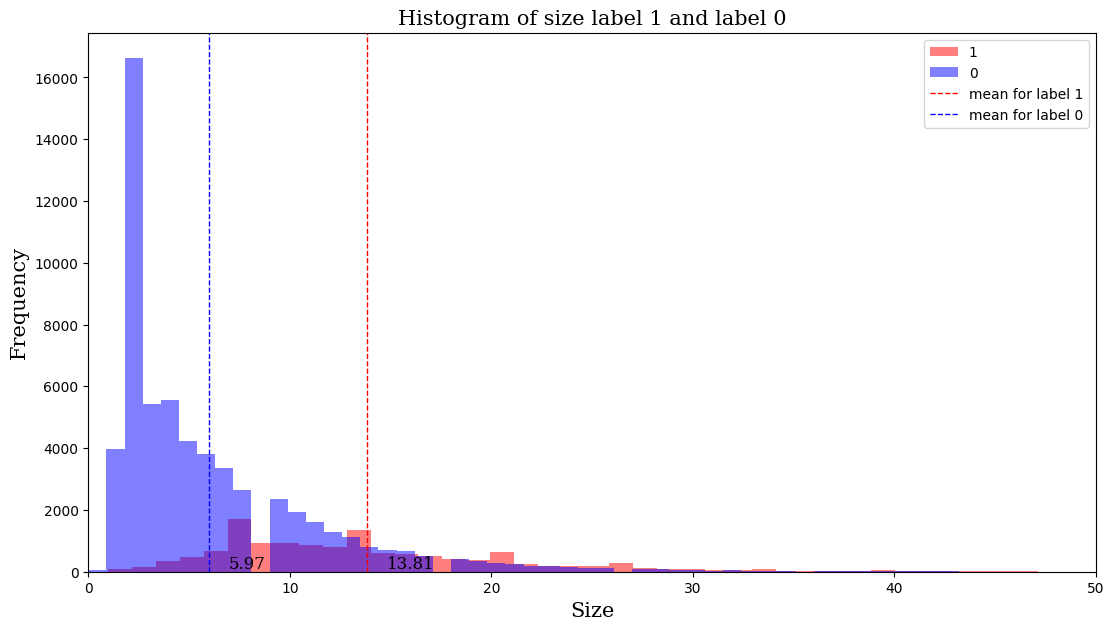

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 7))
plt.hist(data[data['label'] == 1]['size'], bins=60, alpha=0.5, label='1', color='red')
plt.hist(data[data['label'] == 0]['size'], bins=60, alpha=0.5, label='0', color='blue')
# vertical bar for mean
plt.axvline(data[data['label'] == 1]['size'].mean(), color='red', linestyle='dashed', linewidth=1, label='mean for label 1')
plt.axvline(data[data['label'] == 0]['size'].mean(), color='blue', linestyle='dashed', linewidth=1, label='mean for label 0')
# add value mean

plt.text(data[data['label'] == 1]['size'].mean()+1, 100, round(data[data['label'] == 1]['size'].mean(), 2), fontsize=12, fontname="Serif")
plt.text(data[data['label'] == 0]['size'].mean()+1, 100, round(data[data['label'] == 0]['size'].mean(), 2), fontsize=12, fontname="Serif")
# set x lim to 50
plt.xlim(0, 50)

plt.xlabel('Size', fontsize=15, fontname="Serif")
plt.ylabel('Frequency', fontsize=15, fontname="Serif")

plt.legend(loc='upper right')
plt.title('Histogram of size label 1 and label 0', fontsize=15, fontname="Serif")
plt.show()


## Speaker 

We map the different speakers between 1 to 4.

In [11]:
speakers = data['speaker'].unique()
dict_speakers = {}
for index, speaker in enumerate(speakers):
    dict_speakers[speaker] = int(index)+1

data['type_speaker'] = data['speaker'].map(dict_speakers)
data.head()


,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,42,43,44,45,46,47,48,49,size,type_speaker
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000,0.280351,0.668325,...,0.306713,-0.005709,0.341717,-0.758532,-0.302746,0.190208,0.680299,0.567384,1,1
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000,0.097474,0.517865,...,0.279669,-0.174053,0.041601,-1.100189,0.109840,-0.022077,0.374076,0.594494,1,1
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125,-0.057106,0.304370,...,-0.110884,0.166289,0.260028,-0.192708,0.089960,0.064799,0.019278,0.145528,12,1
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000,-0.127117,0.099306,...,-0.027908,0.099480,0.427007,-0.111711,-0.007162,-0.180721,-0.030948,-0.202711,3,1
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125,0.247340,0.244565,...,0.026867,0.055332,0.225649,-0.432288,0.028670,-0.009903,0.171076,-0.134297,15,1


## New word

Indicates if there is a new and unusual word in a message.

In [12]:
## most common words
from collections import Counter

top_words = Counter(" ".join(data["cleaned_text"]).split()).most_common(300)
max_count = top_words[0][1]
top_words = [word[0] for word in top_words]

In [13]:
from collections import Counter

for transcription_id in data['transcription_id'].unique():
    transcription = data[data['transcription_id'] == transcription_id]
    already_seen = []
    word_counter = Counter()
    
    for index, row in transcription.iterrows():
        if row['cleaned_text'] == '':
            data.loc[index, 'new'] = 0
            data.loc[index, 'rank_appearance'] = max_count
        else:
            words = row['cleaned_text'].split()
            min_word_counter = max_count
            for word in words:
                if word not in top_words and word not in already_seen:
                    word_counter[word] += 1
                    if word_counter[word] < min_word_counter:
                        min_word_counter = word_counter[word]
                    data.loc[index, 'new'] = 1
                else:
                    data.loc[index, 'new'] = 0
                
            data.loc[index, 'rank_appearance'] = min_word_counter

data.loc[data['new'] == 1].head()

,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,44,45,46,47,48,49,size,type_speaker,new,rank_appearance
51,ME,"And , yeah that they have lots of personality",51,ES2002a,1,"and , yeah that they have lots of personality",0.000296,0.03125,0.129119,0.103284,...,0.258367,-0.294874,0.015139,-0.143078,-0.054481,-0.157671,9,2,1.0,1.0
112,PM,and very kind of affectionate,112,ES2002a,0,and very kind of affectionate,0.000226,0.00000,-0.068899,0.065526,...,0.204303,-0.241028,-0.087269,-0.168799,-0.068178,-0.305254,5,1,1.0,1.0
119,PM,He only does it after he's had his dinner,119,ES2002a,0,he only does it after he's had his dinner,0.000308,0.00000,0.243262,0.088682,...,0.357812,-0.186140,-0.119594,-0.266534,0.155308,0.041733,9,1,1.0,1.0
140,ME,"Uh , so bas at twel",140,ES2002a,0,"uh , so bas at twel",0.000240,0.03125,-0.024540,0.220204,...,0.320897,-0.254199,0.015729,-0.068655,0.016937,-0.100356,6,2,1.0,1.0
147,PM,I imagine <disfmarker>,147,ES2002a,0,i imagine,0.000145,0.03125,-0.001595,0.317823,...,0.276726,-0.010199,-0.114028,-0.390778,-0.053886,-0.388708,2,1,1.0,1.0


## Analyse feelings

We use the nltk sentiment analyser to computer wether a message is positive, negative, or neutral. It might be linked to the importance of the messages.

In [14]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores for each text
def get_sentiment_scores(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores

# Apply sentiment analysis to the 'cleaned_text' column
data['sentiment_scores'] = data['cleaned_text'].apply(get_sentiment_scores)

# Extract sentiment scores into separate columns
data['compound_sentiment'] = data['sentiment_scores'].apply(lambda x: x['compound'])
data['positive_sentiment'] = data['sentiment_scores'].apply(lambda x: x['pos'])
data['negative_sentiment'] = data['sentiment_scores'].apply(lambda x: x['neg'])
data['neutral_sentiment'] = data['sentiment_scores'].apply(lambda x: x['neu'])
data.drop('sentiment_scores', axis=1, inplace=True)
data.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mathiasgrau/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,48,49,size,type_speaker,new,rank_appearance,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000,0.280351,0.668325,...,0.680299,0.567384,1,1,0.0,44353.0,0.2263,1.000,0.0,0.000
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000,0.097474,0.517865,...,0.374076,0.594494,1,1,0.0,44353.0,0.0000,0.000,0.0,1.000
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125,-0.057106,0.304370,...,0.019278,0.145528,12,1,0.0,1.0,0.2732,0.174,0.0,0.826
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000,-0.127117,0.099306,...,-0.030948,-0.202711,3,1,0.0,44353.0,0.0000,0.000,0.0,1.000
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125,0.247340,0.244565,...,0.171076,-0.134297,15,1,0.0,44353.0,0.0000,0.000,0.0,1.000


## Analyse previous and next link

We have the proportion of important messages following each types of links, so we compute for each message a value that refers to the previous link(s).

In [15]:
train_correspondances_df = pd.read_csv('train_correspondances_df.csv')

coef_dict = {'Acknowledgement': 0.25673684645360284,
            'Continuation': 0.19389174228550185,
            'Elaboration': 0.15097145532407089,
            'Contrast': 0.09784778926786279,
            'Comment': 0.07536179998072236,
            'Question-answer_pair': 0.0671137243022183,
            'Result': 0.049763848918386734,
            'Clarification_question': 0.03810087713258885,
            'Explanation': 0.03194580229403908,
            'Conditional': 0.011869517921319692,
            'Alternation': 0.008151687481927213,
            'Narration': 0.005494127204879996,
            'Q-Elab': 0.005452817977775636,
            'Background': 0.0037040606970243587,
            'Parallel': 0.001555980887597593,
            'Correction': 0.0007022568607741349} # taken from the proportion of label 1 for following message all kind of links 

In [16]:
for transcription_id in data['transcription_id'].unique():
    transcription = data[data['transcription_id'] == transcription_id]
    for index, row in transcription.iterrows():
        previous_links = train_correspondances_df[(train_correspondances_df['transcription_id'] == transcription_id) & (train_correspondances_df['2']==row['index'])]['type'].values
        next_links = train_correspondances_df[(train_correspondances_df['transcription_id'] == transcription_id) & (train_correspondances_df['1']==row['index'])]['type'].values
        previous_coefficient = 0.
        next_coefficient = 0.
        for link in previous_links:
            previous_coefficient += coef_dict[link]
        for link in next_links:
            next_coefficient += coef_dict[link]
        data.loc[index, 'previous_coefficient'] = previous_coefficient
        data.loc[index, 'next_coefficient'] = next_coefficient

data.head()
# ~ 5 minutes to run

,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,size,type_speaker,new,rank_appearance,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,previous_coefficient,next_coefficient
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000,0.280351,0.668325,...,1,1,0.0,44353.0,0.2263,1.000,0.0,0.000,0.000000,0.193892
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000,0.097474,0.517865,...,1,1,0.0,44353.0,0.0000,0.000,0.0,1.000,0.193892,0.193892
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125,-0.057106,0.304370,...,12,1,0.0,1.0,0.2732,0.174,0.0,0.826,0.193892,0.031946
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000,-0.127117,0.099306,...,3,1,0.0,44353.0,0.0000,0.000,0.0,1.000,0.031946,0.150971
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125,0.247340,0.244565,...,15,1,0.0,44353.0,0.0000,0.000,0.0,1.000,0.150971,0.193892


## Important word

It is the ratio of the count of the words in important messages over non important messages.

In [17]:
## count words where label = 1

top_important_words = Counter(" ".join(data.loc[data['label']==1]["cleaned_text"]).split()).most_common(300)
top_important_words = dict(top_important_words)
print("Top_important_words : ", top_important_words)
top_non_important_words = Counter(" ".join(data.loc[data['label']==0]["cleaned_text"]).split()).most_common(300)
top_non_important_words = dict(top_non_important_words)
print("Top non important words : ", top_non_important_words)

def ratio_importance(word, top_important_words, top_non_important_words):
    if word in top_important_words.keys():
        if word in top_non_important_words.keys():
            return top_important_words[word]/top_non_important_words[word]
        else:
            return 3.
    else:
        if word in top_non_important_words.keys():
            return 0.
        else:
            return 1.

## add ratio importance column to train_df
data['ratio_importance'] = data['cleaned_text'].apply(lambda x: max([ratio_importance(word, top_important_words, top_non_important_words) for word in x.split() ] if x != '' else [0.]))
data.head()

Top_important_words :  {'the': 9408, ',': 8582, '.': 7820, 'uh': 4783, 'to': 4402, 'and': 4318, 'a': 4226, 'we': 3647, 'i': 3465, 'you': 3024, 'of': 2964, 'it': 2821, 'that': 2654, 'um': 2460, 'have': 2086, 'is': 2044, 'so': 1727, 'be': 1647, 'in': 1578, 'for': 1548, 'on': 1502, 'think': 1393, 'like': 1355, "it's": 1315, 'can': 1205, 'but': 1194, 'remote': 1189, 'this': 1150, 'if': 1133, 'with': 1065, 'or': 1005, 'just': 967, '?': 960, 'are': 942, 'what': 877, 'one': 851, 'then': 828, 'control': 773, 'do': 756, 'buttons': 748, 'not': 699, 'as': 680, 'about': 667, 'use': 648, 'know': 644, 'our': 643, 'will': 611, 'well': 610, 'would': 597, 'maybe': 587, 'they': 586, 'more': 585, 'some': 578, 'yeah': 575, 'design': 555, 'should': 538, 'something': 536, 'want': 526, 'could': 521, "we're": 502, 'make': 496, 'all': 487, 'at': 481, "don't": 470, "that's": 460, 'gonna': 442, 'also': 441, 'an': 438, 'your': 429, 'very': 422, 'need': 418, 'button': 416, 'was': 415, 'thing': 408, 'people': 407, 

,speaker,text,index,transcription_id,label,cleaned_text,tfidf_score,tfidf_score_per_speaker,0,1,...,type_speaker,new,rank_appearance,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,previous_coefficient,next_coefficient,ratio_importance
0,PM,Okay,0,ES2002a,0,okay,0.000114,0.00000,0.280351,0.668325,...,1,0.0,44353.0,0.2263,1.000,0.0,0.000,0.000000,0.193892,0.050021
1,PM,Right,1,ES2002a,0,right,0.000114,0.00000,0.097474,0.517865,...,1,0.0,44353.0,0.0000,0.000,0.0,1.000,0.193892,0.193892,0.129602
2,PM,<vocalsound> Um well this is the kick-off meet...,2,ES2002a,1,um well this is the kick-off meeting for our o...,0.000337,0.03125,-0.057106,0.304370,...,1,0.0,1.0,0.2732,0.174,0.0,0.826,0.193892,0.031946,1.096654
3,PM,Um <vocalsound> and um,3,ES2002a,0,um and um,0.000150,0.00000,-0.127117,0.099306,...,1,0.0,44353.0,0.0000,0.000,0.0,1.000,0.031946,0.150971,0.748094
4,PM,this is just what we're gonna be doing over th...,4,ES2002a,0,this is just what we're gonna be doing over th...,0.000448,0.03125,0.247340,0.244565,...,1,0.0,44353.0,0.0000,0.000,0.0,1.000,0.150971,0.193892,0.842935


## Machine learning models

### Data Preparation

We have 2 choices, either we chose to split the data by transcriptions, so 80% of transcriptions will be considered as training set, and 20% of transcription as testing set. Or we can just select all messages independantly and separate them in a training and a testing set.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



train_by_transcription = True

if train_by_transcription:
    train_transcriptions_ids = data['transcription_id'].unique()
    ids_for_training = np.random.choice(train_transcriptions_ids, size=int(len(train_transcriptions_ids)*0.8), replace=False)
    ids_for_testing = np.setdiff1d(train_transcriptions_ids, ids_for_training)

    X_train = data[data['transcription_id'].isin(ids_for_training)].drop(['speaker', 'text', 'transcription_id', 'label', 'cleaned_text'], axis=1).reset_index(drop=True)

    y_train = data[data['transcription_id'].isin(ids_for_training)]['label']
    X_test = data[data['transcription_id'].isin(ids_for_testing)].drop(['speaker', 'text',  'transcription_id', 'label', 'cleaned_text'], axis=1).reset_index(drop=True)

    y_test = data[data['transcription_id'].isin(ids_for_testing)]['label']

    scaler = StandardScaler()
    columns = X_train.columns
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=columns)
    X_test = pd.DataFrame(X_test, columns=columns)
else : 
    X = data.drop(['speaker', 'text', 'index', 'transcription_id', 'label', 'cleaned_text'], axis=1).astype(float)
    y = data['label']
    X_columns = X.columns
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X= pd.DataFrame(X, columns=X_columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Classic logistic regression

In [19]:
# logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)

print(classification_report(y_test, y_pred_log))


              precision    recall  f1-score   support

           0       0.96      0.75      0.84     14664
           1       0.36      0.80      0.50      2579

    accuracy                           0.76     17243
   macro avg       0.66      0.78      0.67     17243
weighted avg       0.87      0.76      0.79     17243



### Different threshold

In [20]:

# Train your model on the oversampled data
# For example, if you're using a logistic regression model:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = logreg.predict_proba(X_test)


In [21]:
from sklearn.metrics import f1_score
def best_threshold(y_test, y_pred_proba):
    best_threshold = 0.
    best_f1 = 0.
    for threshold in np.arange(0.1, 0.9, 0.02):
        y_pred = (y_pred_proba[:, 1] > threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print("best_threshold : ", best_threshold)
    return best_threshold

best_thre = best_threshold(y_test, y_pred_proba)

y_pred = (y_pred_proba[:, 1] > best_thre).astype(int)  # Set a lower threshold of 0.3

# Evaluate the performance of the model
print("mean : ",y_pred.mean())
print(classification_report(y_test, y_pred))


best_threshold :  0.66
mean :  0.22461288638867946
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     14664
           1       0.43      0.65      0.52      2579

    accuracy                           0.82     17243
   macro avg       0.68      0.75      0.71     17243
weighted avg       0.86      0.82      0.83     17243



### Dealing with minority class : upsampling

In [22]:
## refit using smote

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


# Train your model on the oversampled data
# For example, if you're using a logistic regression model:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_smote, y_smote)

# Make predictions on the test set
y_pred_proba_smote = logreg.predict_proba(X_test)

best_thre = best_threshold(y_test, y_pred_proba_smote)

y_pred = (y_pred_proba_smote[:, 1] > best_thre).astype(int) 

# Evaluate the performance of the model

print("mean : ",y_pred.mean())

print(classification_report(y_test, y_pred))


best_threshold :  0.6200000000000001
mean :  0.2406773763266253
              precision    recall  f1-score   support

           0       0.94      0.84      0.88     14664
           1       0.42      0.68      0.52      2579

    accuracy                           0.81     17243
   macro avg       0.68      0.76      0.70     17243
weighted avg       0.86      0.81      0.83     17243



In [23]:
## upsample minority class

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

from sklearn.utils import resample

X_minority_upsampled, y_minority_upsampled = resample(X_minority, y_minority, replace=True, n_samples=X_majority.shape[0], random_state=42)

X_train_upsampled = pd.concat([X_minority_upsampled, X_majority])
y_train_upsampled = pd.concat([y_minority_upsampled, y_majority])

logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_upsampled, y_train_upsampled)

y_pred_proba = logreg.predict_proba(X_test)

best_thre = best_threshold(y_test, y_pred_proba)

y_pred = (y_pred_proba[:, 1] > best_thre).astype(int)  # Set a lower threshold of 0.3

# Evaluate the performance of the model
print("mean : ",y_pred.mean())
print(classification_report(y_test, y_pred))

best_threshold :  0.66
mean :  0.22519283187380387
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     14664
           1       0.43      0.65      0.52      2579

    accuracy                           0.82     17243
   macro avg       0.68      0.75      0.71     17243
weighted avg       0.86      0.82      0.83     17243



### Calculating the importance of each feature

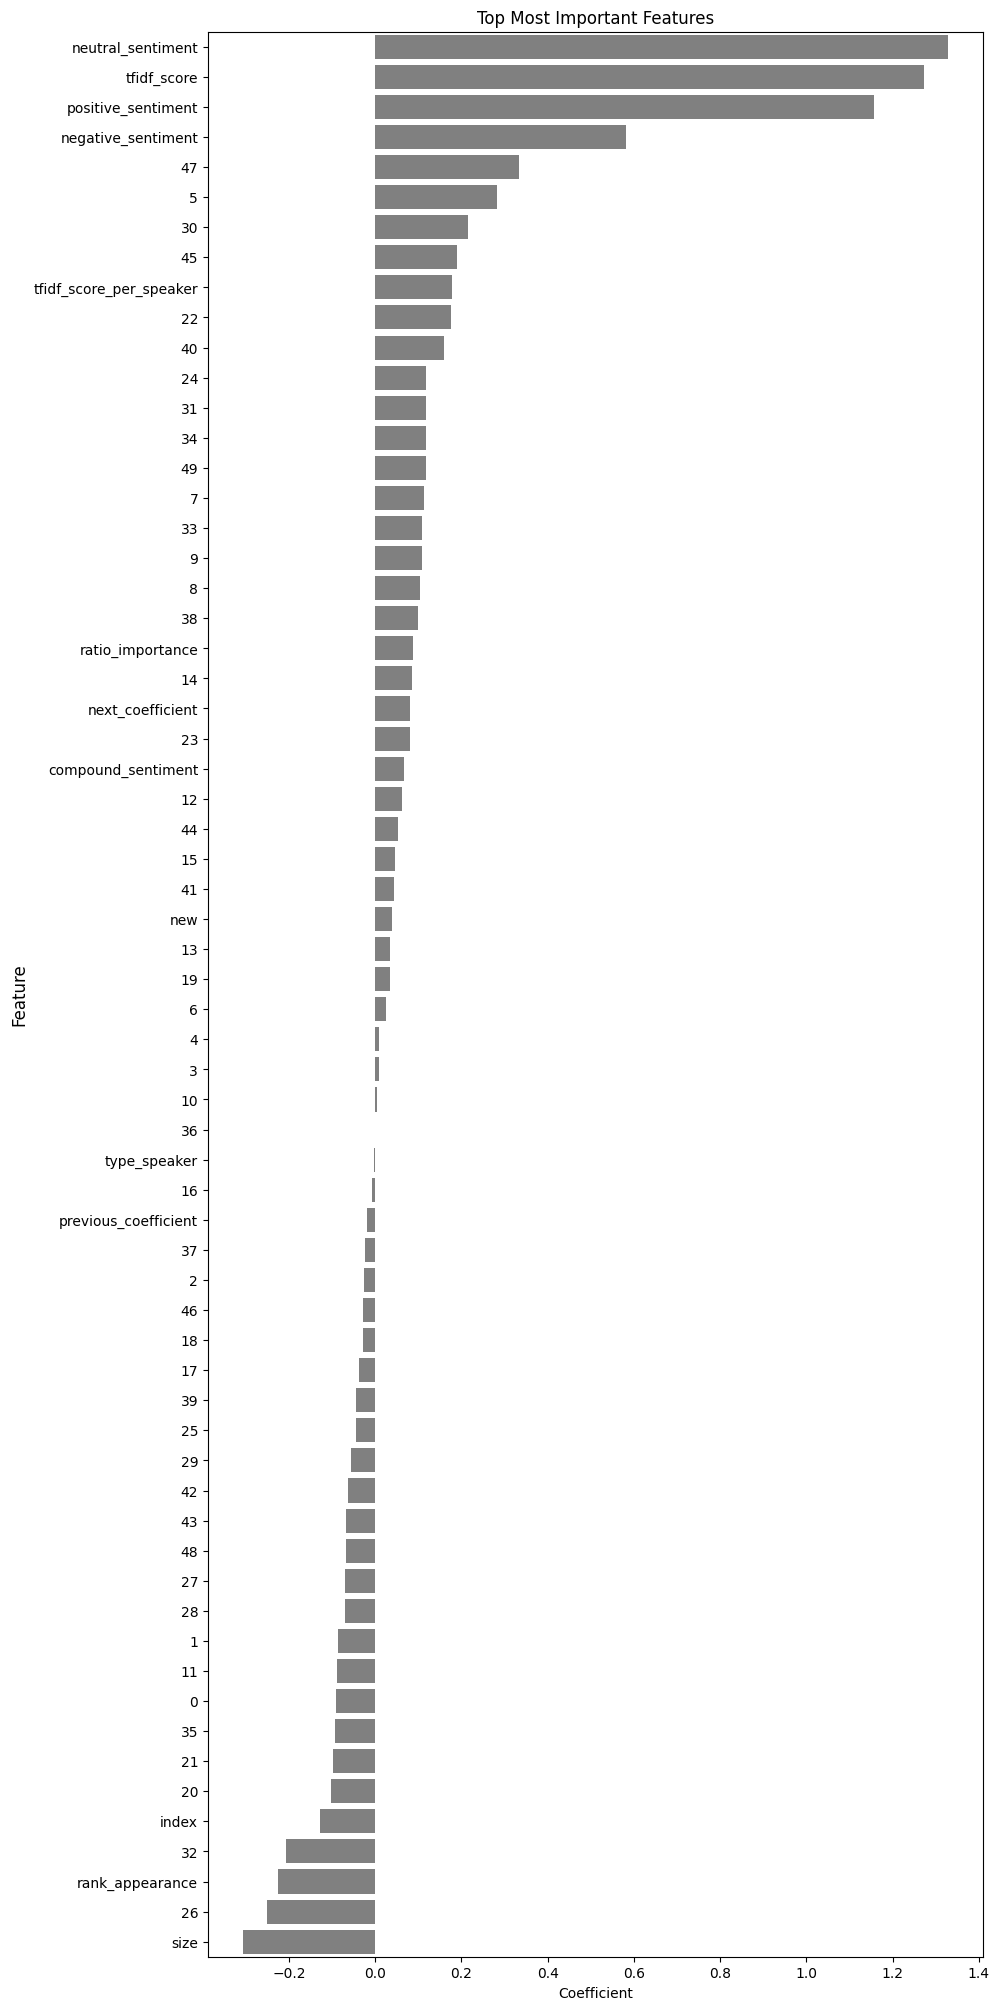

In [87]:
## most important features according to logistic regression

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

## most important features according to logistic regression

import matplotlib.pyplot as plt

# Sort the coefficients in descending order
sorted_coefficients = sorted(zip(logreg.coef_[0], X_train_upsampled.columns), reverse=True)

# Select the top 10 features
top_features = sorted_coefficients[:200]

# Extract the coefficients and feature names
coefficients = [coef for coef, feature in top_features]
features = [feature for coef, feature in top_features]

# Plot the bar chart
plt.figure(figsize=(10, 25))
sns.barplot(x=coefficients, y=features, color = "grey")
plt.xlabel('Coefficient')
plt.ylabel('Feature', size=12)
plt.title('Top Most Important Features')
plt.show()



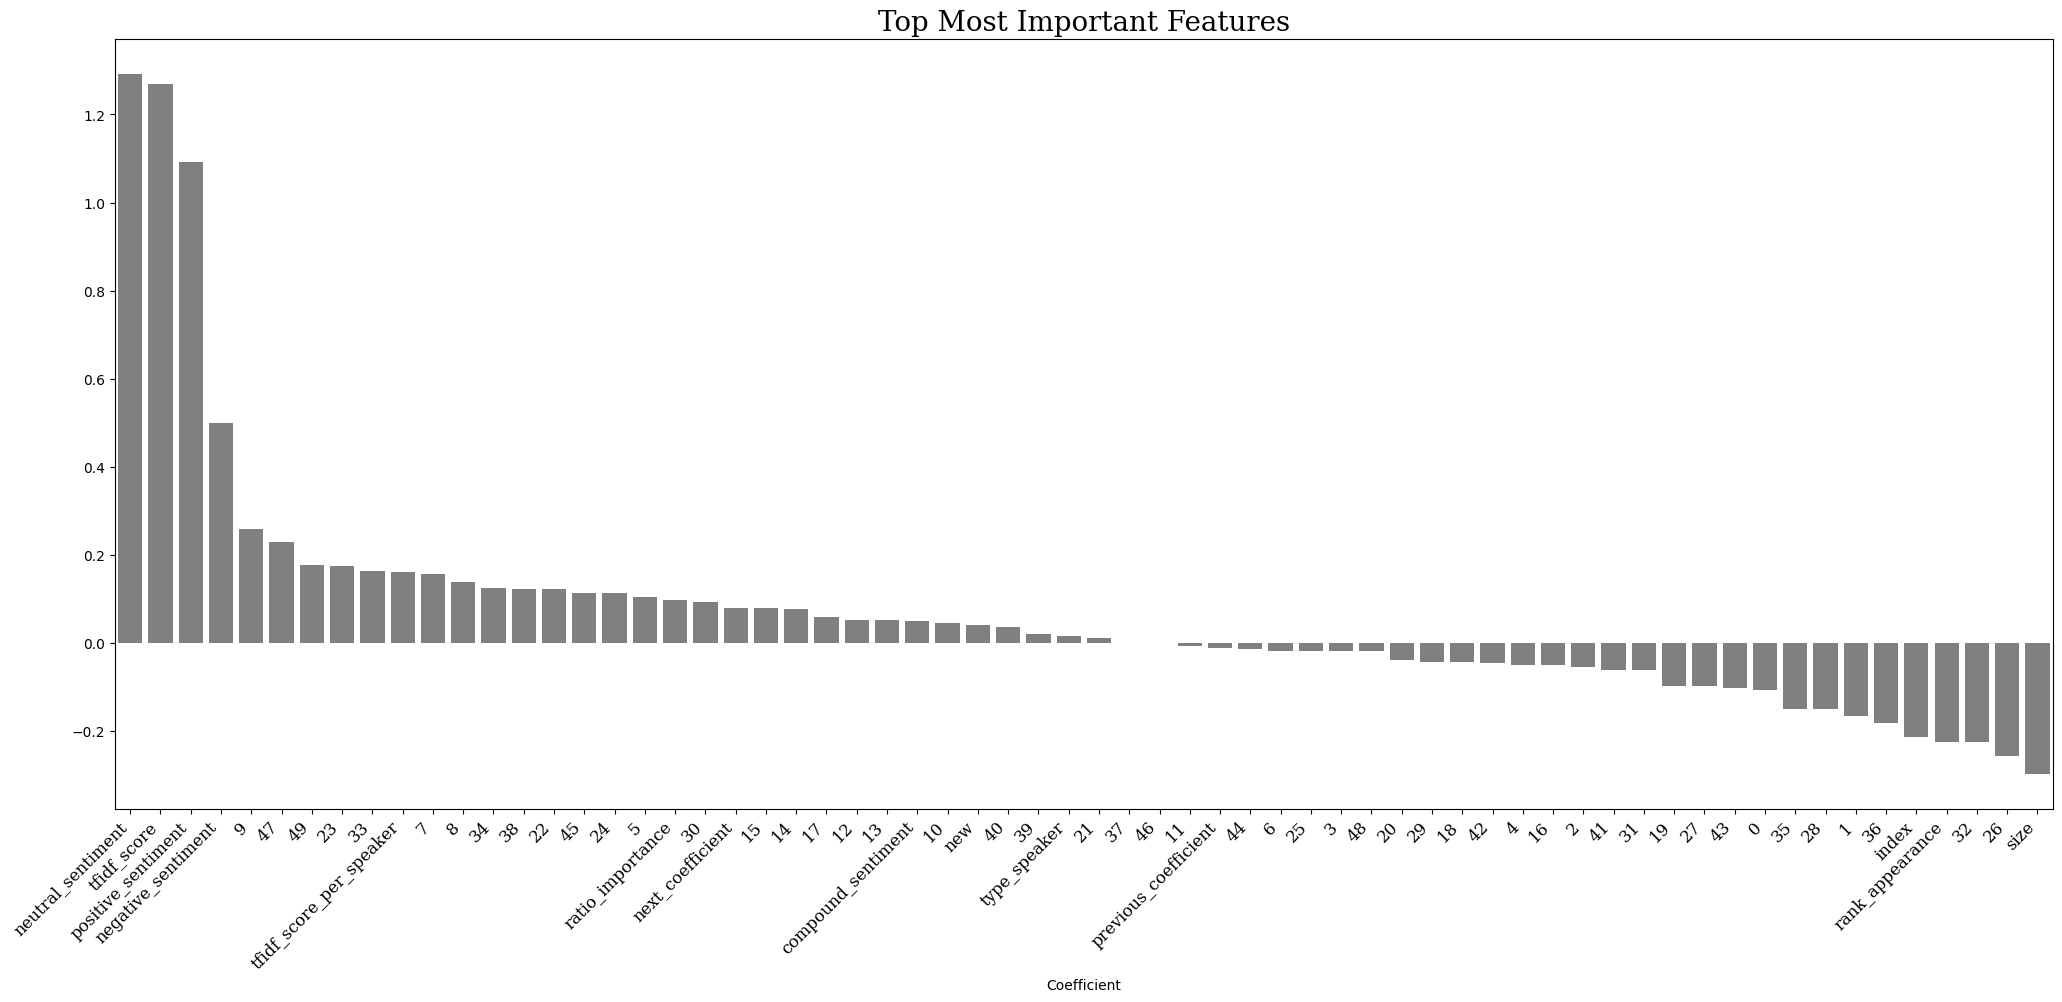

In [32]:
## plot horizontally

import matplotlib.pyplot as plt
import seaborn as sns

# Sort the coefficients in descending order
sorted_coefficients = sorted(zip(logreg.coef_[0], X_train_upsampled.columns), reverse=True)

# Select the top 10 features
top_features = sorted_coefficients[:200]

# Extract the coefficients and feature names
coefficients = [coef for coef, feature in top_features]
features = [feature for coef, feature in top_features]

# Plot the bar chart
plt.figure(figsize=(25, 10))
ax = sns.barplot(x=features, y=coefficients, color="grey")
plt.xlabel('Coefficient')
plt.xticks(rotation=45, ha='right',fontsize=12, fontname = "Serif")  # Rotate x labels by 45 degrees and align them at the end
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')  # Align labels at the end
plt.title('Top Most Important Features', fontsize=20, fontname='Serif')
plt.show()

## Decision tree classifiers

In [69]:
## random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.84      0.97      0.90     10385
           1       0.66      0.26      0.37      2606

    accuracy                           0.82     12991
   macro avg       0.75      0.61      0.64     12991
weighted avg       0.80      0.82      0.79     12991



In [88]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, max_depth=7, n_estimators=1000, learning_rate=0.01, objective='binary:logistic', eval_metric='logloss')
xgb.fit(X_train_upsampled, y_train_upsampled)

y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85     11029
           1       0.51      0.82      0.63      3077

    accuracy                           0.79     14106
   macro avg       0.72      0.80      0.74     14106
weighted avg       0.84      0.79      0.80     14106



### KNN classifier

In [26]:
## knn classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_upsampled, y_train_upsampled)

y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

### Support Vector Machines

Quite long given the large size of the dataset

In [ ]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced', random_state=42, probability=True)
svc.fit(X_train_upsampled, y_train_upsampled)

y_pred_svc = svc.predict(X_test)

print(classification_report(y_test, y_pred_svc))


## Conclusion on Logistic Regression and XGBoost

In [ ]:
print("Using logistic")
print(classification_report(y_test, y_pred))
print("Using xgboost")
print(classification_report(y_test, y_pred_xgb))
print("Using max")
y_pred_proba_max = np.maximum(y_pred, y_pred_xgb) ## max for each coordinate of y pred in all model 
print(classification_report(y_test, y_pred_proba_max))

Using logistic
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     12265
           1       0.43      0.73      0.54      2426

    accuracy                           0.79     14691
   macro avg       0.68      0.77      0.70     14691
weighted avg       0.85      0.79      0.81     14691

Using xgboost
              precision    recall  f1-score   support

           0       0.95      0.76      0.85     12265
           1       0.40      0.80      0.53      2426

    accuracy                           0.77     14691
   macro avg       0.68      0.78      0.69     14691
weighted avg       0.86      0.77      0.79     14691

Using max
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     12265
           1       0.39      0.82      0.53      2426

    accuracy                           0.76     14691
   macro avg       0.67      0.78      0.68     14691
weighted avg       0.86      0.76  

### Analysis looking only on important features

In [ ]:
## select best features using selectkbest

from sklearn.feature_selection import SelectKBest, f_classif

# Set k to 0.2 to select the top 20% of features
selector = SelectKBest(f_classif, k=int(0.2 * len(X_train.columns)))
X_new = selector.fit_transform(X_train, y_train)

# Create a DataFrame with the selected features
selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                 index=X_train.index,
                                 columns=X_train.columns)

# Identify the selected and non-selected columns
selected_columns = selected_features.columns[selected_features.var() != 0]
non_selected_columns = selected_features.columns[selected_features.var() == 0]

selected_columns

Index(['tfidf_score', 'tfidf_score_per_speaker', '1', '18', '25', '26', '28',
       '49', 'size', 'rank_appearance', 'neutral_sentiment',
       'ratio_importance'],
      dtype='object')

In [ ]:
## try with only selected features

Xnew = data[selected_columns]
ynew = data['label']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(Xnew, ynew, test_size=0.2, random_state=42)

## logistic regression

logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_new, y_train_new)

y_pred_proba = logreg.predict_proba(X_test_new)

best_thre = best_threshold(y_test_new, y_pred_proba)

y_pred_best_features = (y_pred_proba[:, 1] > best_thre).astype(int)  # Set a lower threshold of 0.3

# Evaluate the performance of the model

print(classification_report(y_test_new, y_pred_best_features))

best_threshold :  0.66
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     11887
           1       0.43      0.70      0.53      2638

    accuracy                           0.78     14525
   macro avg       0.68      0.75      0.69     14525
weighted avg       0.83      0.78      0.80     14525



It is not satisfactory

## Conclusion

So for a submission on kaggle, we will keep the xgboost classifier with upsampled classes, because it has shown to be the best ML classifier (regardless of Neural Networks).

## For a submission :

In [ ]:
test_transcription_df = pd.read_csv('test_transcriptions_df.csv')
test_transcription_df.head()

In [ ]:
test_transcription_df['cleaned_text'] = test_transcription_df['text'].apply(preprocess_sentence)
test_transcription_df.head()

In [ ]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize)
test_transcription_df['tfidf_score'] = tfidf.fit_transform(test_transcription_df['cleaned_text']).mean(axis=1)
test_transcription_df.head()

In [ ]:
test_transcription_ids = test_transcription_df['transcription_id'].tolist()

test_transcription_df['tfidf_score_per_speaker'] = np.nan
for speaker in test_transcription_df['speaker'].unique():
    speaker_transcription = test_transcription_df[test_transcription_df['speaker'] == speaker]
    corpus = speaker_transcription['cleaned_text'].tolist()
    corpus = [' '.join(doc).split() for doc in corpus]
    vectoriser = TfidfVectorizer(tokenizer=word_tokenize)
    vectoriser.fit_transform([' '.join(doc) for doc in corpus])
    speaker_indices = test_transcription_df[test_transcription_df['speaker'] == speaker].index
    speaker_test_transcription_df = vectoriser.transform(test_transcription_df.loc[speaker_indices, 'cleaned_text'])
    test_transcription_df.loc[speaker_indices, 'tfidf_score_per_speaker'] = speaker_test_transcription_df.mean(axis=1).A1  # Convert to a 1D array
test_transcription_df.head()

In [ ]:
X_word2vec = test_transcription_df['cleaned_text'].apply(lambda sentence: sentence_to_avg_vector(sentence, word2vec_model))
# Convertir X_word2vec en une liste de vecteurs, puis en une matrice NumPy
X_word2vec_matrix = np.vstack(X_word2vec.values)
X_word2vec_df = pd.DataFrame(X_word2vec_matrix)

# concaténation des deux test_transcription_dfframes
test_transcription_df = pd.concat([test_transcription_df, X_word2vec_df], axis=1)
test_transcription_df.columns = test_transcription_df.columns.astype(str)
test_transcription_df.head()

In [ ]:
test_transcription_df['cleaned_text'] = test_transcription_df['cleaned_text'].astype(str)
test_transcription_df['size'] = test_transcription_df['cleaned_text'].apply(lambda x: len(x.split()))
test_transcription_df.head()

In [ ]:
speakers = test_transcription_df['speaker'].unique()
dict_speakers = {}
for index, speaker in enumerate(speakers):
    dict_speakers[speaker] = int(index)+1

test_transcription_df['type_speaker'] = test_transcription_df['speaker'].map(dict_speakers)
test_transcription_df.head()

In [ ]:
for transcription_id in test_transcription_df['transcription_id'].unique():
    transcription = test_transcription_df[test_transcription_df['transcription_id'] == transcription_id]
    already_seen = []
    word_counter = Counter()
    
    for index, row in transcription.iterrows():
        if row['cleaned_text'] == '':
            test_transcription_df.loc[index, 'new'] = 0
            test_transcription_df.loc[index, 'rank_appearance'] = max_count
        else:
            words = row['cleaned_text'].split()
            min_word_counter = max_count
            for word in words:
                if word not in top_words and word not in already_seen:
                    word_counter[word] += 1
                    if word_counter[word] < min_word_counter:
                        min_word_counter = word_counter[word]
                    test_transcription_df.loc[index, 'new'] = 1
                else:
                    test_transcription_df.loc[index, 'new'] = 0
                
            test_transcription_df.loc[index, 'rank_appearance'] = min_word_counter

test_transcription_df.loc[test_transcription_df['new'] == 1].head()

In [ ]:
# Apply sentiment analysis to the 'cleaned_text' column
test_transcription_df['sentiment_scores'] = test_transcription_df['cleaned_text'].apply(get_sentiment_scores)

# Extract sentiment scores into separate columns
test_transcription_df['compound_sentiment'] = test_transcription_df['sentiment_scores'].apply(lambda x: x['compound'])
test_transcription_df['positive_sentiment'] = test_transcription_df['sentiment_scores'].apply(lambda x: x['pos'])
test_transcription_df['negative_sentiment'] = test_transcription_df['sentiment_scores'].apply(lambda x: x['neg'])
test_transcription_df['neutral_sentiment'] = test_transcription_df['sentiment_scores'].apply(lambda x: x['neu'])
test_transcription_df.drop('sentiment_scores', axis=1, inplace=True)
test_transcription_df.head()

In [ ]:
test_correspondances_df = pd.read_csv('test_correspondances_df.csv')
for transcription_id in test_transcription_df['transcription_id'].unique():
    transcription = test_transcription_df[test_transcription_df['transcription_id'] == transcription_id]
    for index, row in transcription.iterrows():
        previous_links = test_correspondances_df[(test_correspondances_df['transcription_id'] == transcription_id) & (test_correspondances_df['2']==row['index'])]['type'].values
        next_links = test_correspondances_df[(test_correspondances_df['transcription_id'] == transcription_id) & (test_correspondances_df['1']==row['index'])]['type'].values
        previous_coefficient = 0.
        next_coefficient = 0.
        for link in previous_links:
            previous_coefficient += coef_dict[link]
        for link in next_links:
            next_coefficient += coef_dict[link]
        test_transcription_df.loc[index, 'previous_coefficient'] = previous_coefficient
        test_transcription_df.loc[index, 'next_coefficient'] = next_coefficient

test_transcription_df.head()

In [ ]:
## add ratio importance column to train_df
test_transcription_df['ratio_importance'] = test_transcription_df['cleaned_text'].apply(lambda x: max([ratio_importance(word, top_important_words, top_non_important_words) for word in x.split() ] if x != '' else [0.]))
test_transcription_df.head()

In [ ]:
X_train = data.drop(['speaker', 'text', 'transcription_id', 'label', 'cleaned_text'], axis=1).reset_index(drop=True)

y_train = data['label']

scaler = StandardScaler()
columns = X_train.columns
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns)

In [ ]:

X_test = test_transcription_df.drop(['speaker', 'text',  'transcription_id', 'cleaned_text'], axis=1).reset_index(drop=True)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns)

In [ ]:
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

from sklearn.utils import resample

X_minority_upsampled, y_minority_upsampled = resample(X_minority, y_minority, replace=True, n_samples=X_majority.shape[0]//2)

X_train_upsampled = pd.concat([X_minority_upsampled, X_majority])
y_train_upsampled = pd.concat([y_minority_upsampled, y_majority])
xgb_final = XGBClassifier(random_state=42, max_depth=7, n_estimators=1000, learning_rate=0.01, objective='binary:logistic', eval_metric='logloss')
xgb_final.fit(X_train_upsampled, y_train_upsampled)
y_test_pred_xgb = xgb_final.predict(X_test)
y_test_pred_xgb.mean()

In [ ]:
test_transcription_df['id'] = test_transcription_df['transcription_id'].astype(str) + '_' + test_transcription_df['index'].astype(str)
final_df = pd.DataFrame({'id': test_transcription_df['id'], 'target_feature': y_test_pred_xgb})
final_df.head()

In [ ]:
final_df.to_csv('submission.csv', index=False)